In [10]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_selection import VarianceThreshold, f_classif, chi2, mutual_info_classif, SelectKBest

In [2]:
BASE_DIR        = '../' 
FEATURES_DIR    = 'Features/'
ALL_USERS_DIR   = 'All/'
IND_USER_DIR    = 'Individuals/'
LOG_DIR         = 'Logs/'

USERS           = ['001', '002', '003', '004', '005', '006', '007']
GESTURES        = ['j', 'z', 'bad', 'deaf', 'fine', 'good', 'goodbye', 'hello', 'hungry',
                   'me', 'no', 'please', 'sorry', 'thankyou', 'yes', 'you']

WINDOW_LEN      = 150

# ------------- FOR THE GREATER GOOD :) ------------- #
DATASET_LEN     = 1120
TRAIN_LEN       = 960
TEST_LEN        = 160

TEST_USER       = '001'
EPOCHS          = 5

# ------------------ RnF Tuning -------------------
CRITERION       = 'entropy'
N_ESTIMATORS    = 128
MAX_DEPTH       = 32

#-------- Feature Importance ---------
VAR_THRESHOLD   = 0.7
K = 220

CONFIG          = 'MI_RF_E_NE128_D32' + '_VT_' + str(VAR_THRESHOLD) + '_K_' + str(K) + '\n'

In [3]:
# path = os.path.join(BASE_DIR, FEATURES_DIR, ALL_USERS_DIR, 'FEATURES_ALL_USERS.joblib')
# data = joblib.load(path)
# X = data.drop(columns=['y'])
# y = data['y']

In [4]:
# FEATURES = X.columns

In [5]:
# sel = VarianceThreshold(threshold=(VAR_THRESHOLD * (1 - VAR_THRESHOLD)))
# X = sel.fit_transform(X)

In [6]:
# X = SelectKBest(f_classif, k=2).fit_transform(X, y)

In [7]:
ACC = 0
logs = ''

for test_user in USERS:
    print('Processing results for user ' + test_user, end='... ')
    
    train = pd.DataFrame()
    test = pd.DataFrame()

    for user in USERS:
        feature_path = os.path.join(BASE_DIR, FEATURES_DIR, IND_USER_DIR, user + '.joblib')
        features = joblib.load(feature_path)

        if user == test_user:
            test = pd.concat([test, features], ignore_index=True)
        else:
            train = pd.concat([train, features], ignore_index=True)

    X_train = train.drop(columns=['y']).to_numpy()
    X_test = test.drop(columns=['y']).to_numpy()

    y_train = train['y'].to_numpy()
    y_test = test['y'].to_numpy()

    X_train, y_train = shuffle(X_train, y_train)
    
    sel = VarianceThreshold(threshold=(VAR_THRESHOLD * (1 - VAR_THRESHOLD)))
    X_train = sel.fit_transform(X_train)
    X_test = sel.transform(X_test)
    
    k_best = SelectKBest(mutual_info_classif, k=K)
    X_train = k_best.fit_transform(X_train, y_train)
    X_test = k_best.transform(X_test)
    

    clf = RandomForestClassifier(
        n_estimators      = N_ESTIMATORS,
        criterion         = CRITERION,
        max_depth         = MAX_DEPTH,
        random_state      = 42,
        verbose           = 0
    )

    acc = 0
    for i in range(EPOCHS):
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        acc = acc + accuracy_score(y_test, y_pred)

    avg_acc = acc / EPOCHS
    print(avg_acc)
    
    logs = logs + 'Average accuracy for user ' + str(test_user) + '... ' + str(avg_acc) + '\n'

    ACC = ACC + avg_acc
    
AVG_ACC = ACC / len(USERS)
print('------------------------------------')
print('Average accuracy -> ' + str(AVG_ACC))

Processing results for user 001... 0.8800000000000001
Processing results for user 002... 0.8575000000000002
Processing results for user 003... 0.8225
Processing results for user 004... 0.665
Processing results for user 005... 0.8175000000000001
Processing results for user 006... 0.8375
Processing results for user 007... 0.6375
------------------------------------
Average accuracy -> 0.7882142857142859


In [8]:
line = '---------------------------------------\n'
log_dir = os.path.join(BASE_DIR, LOG_DIR)
if not os.path.exists(log_dir):
    os.mkdir(log_dir)
f = open(os.path.join(log_dir, 'logs_feature_selection.txt'), 'a')
f.write(CONFIG)
f.write(logs)
f.write(line)
f.write('Average Accuracy on ALL users -> ')
f.write(str(AVG_ACC))
f.write('\n\n')
f.close()

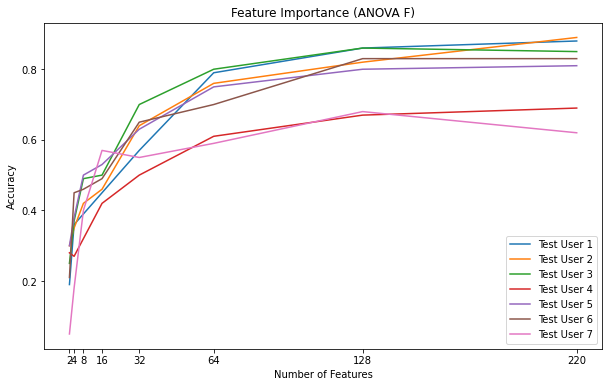

In [17]:
# ANOVA F
nf = np.array([2, 4, 8, 16, 32, 64, 128, 220])

u1 = np.array([0.19, 0.36, 0.39, 0.45, 0.57, 0.79, 0.86, 0.88])
u2 = np.array([0.30, 0.35, 0.42, 0.46, 0.64, 0.76, 0.82, 0.89])
u3 = np.array([0.25, 0.37, 0.49, 0.50, 0.70, 0.80, 0.86, 0.85])
u4 = np.array([0.28, 0.27, 0.32, 0.42, 0.50, 0.61, 0.67, 0.69])
u5 = np.array([0.30, 0.38, 0.50, 0.53, 0.63, 0.75, 0.80, 0.81])
u6 = np.array([0.21, 0.45, 0.46, 0.49, 0.65, 0.70, 0.83, 0.83])
u7 = np.array([0.05, 0.18, 0.40, 0.57, 0.55, 0.59, 0.68, 0.62])

lf = nf
plt.figure(figsize=(10, 6))
plt.plot(lf, u1, lf, u2, lf, u3, lf, u4, lf, u5, lf, u6, lf, u7)
plt.xticks(lf, nf)
plt.legend(['Test User 1', 'Test User 2', 'Test User 3', 'Test User 4', 'Test User 5', 'Test User 6', 'Test User 7'])
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Feature Importance (ANOVA F)')
plt.show()